In [1]:
import numpy as np
import copy
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


In [19]:
np.random.seed(1)
data=pd.read_csv(r"rainfall_data.csv")

In [20]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

data=pd.read_csv(r"rainfall_data.csv")

# create decision tree for target variable
tree = DecisionTreeClassifier(max_depth=4, random_state=42)

# discretize target variable using decision tree
data['rainfall_tree'] = pd.cut(data['rainfall'], bins=6, labels=False)
tree.fit(data[['rainfall']], data['rainfall_tree'])
data['rainfall_tree'] = tree.predict(data[['rainfall']])

# create new columns for the discretized data
data['windspeed_tree'] = tree.predict(pd.cut(data['windspeed'], bins=6, labels=False).values.reshape(-1,1))
data['tpw_tree'] = tree.predict(pd.cut(data['tpw'], bins=6, labels=False).values.reshape(-1,1))

print(data)

           date  windspeed       tpw   rainfall  rainfall_tree  \
0      6/1/2000  12.245595  0.033285   4.688589              0   
1      6/2/2000  12.825491  0.044874  11.330589              0   
2      6/3/2000  12.921664  0.010243   6.894713              0   
3      6/4/2000  15.149001  0.036881   4.613324              0   
4      6/5/2000  18.495907  0.139491   8.111635              0   
...         ...        ...       ...        ...            ...   
2557  9/26/2020   5.577215  0.009963   4.467977              0   
2558  9/27/2020   5.184293  0.002341   1.572182              0   
2559  9/28/2020   4.469007  0.000867   1.819019              0   
2560  9/29/2020   4.259090  0.001416   2.198017              0   
2561  9/30/2020   5.513838  0.002474  12.713634              0   

      windspeed_tree  tpw_tree  
0                  0         0  
1                  0         0  
2                  0         0  
3                  0         0  
4                  0         0  
...      

C:\Users\shine\anaconda3\envs\environment\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\shine\anaconda3\envs\environment\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [21]:
extreme_data=data[data["rainfall"]>30]
normal_data=data[data["rainfall"]<=30]

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import backend as K




def weighted_loss(normal_weight=1, extreme_weight=0.1):
    def loss(y_true, y_pred):
        normal_loss = K.mean(K.square(y_true - y_pred))
        extreme_loss = K.mean(K.square(y_true - y_pred) * K.cast(y_true > 50, 'float32'))
        return K.mean(normal_weight * normal_loss + extreme_weight * extreme_loss)
    return loss
 

# Define a function to find the best regularization strength
def find_best_reg_strength(train_data, reg_strengths, num_epochs, batch_size):
    best_reg_strength = None
    best_loss = float('inf')
    for reg_strength in reg_strengths:
        # Define the autoencoder architecture
        input_layer = Input(shape=(3,))
        encoded = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=reg_strength))(input_layer)
        decoded = Dense(3, activation=None)(encoded)

        # Create the autoencoder
        autoencoder = Model(input_layer, decoded)

        # Compile the autoencoder with the weighted loss function
        autoencoder.compile(optimizer='adam', loss=weighted_loss())

        # Train the model
        history = autoencoder.fit(train_data, train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

        # Calculate the validation loss
        val_loss = np.mean(history.history['val_loss'])

        # Update the best regularization strength and loss
        if val_loss < best_loss:
            best_reg_strength = reg_strength
            best_loss = val_loss

    print('Best regularization strength:', best_reg_strength)
    return best_reg_strength

# Find the best regularization strength
reg_strengths = [0.01, 0.1, 1, 10]
num_epochs = 100
batch_size = 32
train_data = normal_data[["windspeed_tree","tpw_tree","rainfall_tree"]].values.astype("float32")
best_reg_strength = find_best_reg_strength(train_data, reg_strengths, num_epochs, batch_size)

# Define the autoencoder architecture with the best regularization strength
input_layer = Input(shape=(3,))
encoded = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=best_reg_strength))(input_layer)
decoded = Dense(3, activation=None)(encoded)

# Create the autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the autoencoder with the weighted loss function
autoencoder.compile(optimizer='adam', loss=weighted_loss())

# Train the model with the majority class
train_data = normal_data[["windspeed_tree","tpw_tree","rainfall_tree"]].values.astype("float32")
history = autoencoder.fit(train_data, train_data, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# Use the trained autoencoder to predict the rainfall values for all data points
test_data = data[["windspeed_tree","tpw_tree","rainfall_tree"]].values
predicted_data = autoencoder.predict(test_data)
data['predicted_rainfall'] = predicted_data[:, 2]

# Calculate the error between the predicted and actual rainfall values
data['error'] = np.abs(data['predicted_rainfall'] - data['rainfall'])

# Classify the rainfall data into normal and extreme based on the error threshold
threshold = 54.455630194576415

data['rainfall_class'] = np.where(data['error'] > threshold, 'Extreme', 'Normal')

# Define the actual rainfall class based on the threshold of 11
data['actual_rainfall_class'] = np.where(data['rainfall'] >30 , 'Extreme', 'Normal')

# Calculate the accuracy
num_correct = len(data[data['rainfall_class'] == data['actual_rainfall_class']])
num_total = len(data)
accuracy = num_correct / num_total * 100
print('Accuracy: {:.2f}%'.format(accuracy))

Best regularization strength: 0.01
Epoch 1/100
64/64 [==============================] - 1s 3ms/step - loss: 0.0704 - val_loss: 0.0546
Epoch 2/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0453 - val_loss: 0.0363
Epoch 3/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0248
Epoch 4/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0207 - val_loss: 0.0169
Epoch 5/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 6/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 7/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 8/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 9/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 10/100
64/64 [==============================] - 0s 1ms/step - loss: 

64/64 [==============================] - 0s 1ms/step - loss: 2.1297e-04 - val_loss: 2.1196e-04
Epoch 79/100
64/64 [==============================] - 0s 1ms/step - loss: 2.0970e-04 - val_loss: 2.1820e-04
Epoch 80/100
64/64 [==============================] - 0s 1ms/step - loss: 2.0913e-04 - val_loss: 2.0596e-04
Epoch 81/100
64/64 [==============================] - 0s 1ms/step - loss: 2.0319e-04 - val_loss: 2.0169e-04
Epoch 82/100
64/64 [==============================] - 0s 1ms/step - loss: 2.0066e-04 - val_loss: 1.9875e-04
Epoch 83/100
64/64 [==============================] - 0s 1ms/step - loss: 1.9788e-04 - val_loss: 1.9679e-04
Epoch 84/100
64/64 [==============================] - 0s 1ms/step - loss: 1.9480e-04 - val_loss: 1.9358e-04
Epoch 85/100
64/64 [==============================] - 0s 1ms/step - loss: 1.9330e-04 - val_loss: 1.9085e-04
Epoch 86/100
64/64 [==============================] - 0s 1ms/step - loss: 1.9036e-04 - val_loss: 1.8817e-04
Epoch 87/100
64/64 [=====================

In [6]:
data['actual_rainfall_class']=np.array(data['actual_rainfall_class'])
data['predicted_class']=np.array(data['actual_rainfall_class'])

In [33]:
wrong_predictions = data[data['rainfall_class'] != data['actual_rainfall_class']]

# Print the wrong predictions
print(wrong_predictions)

           date  windspeed       tpw   rainfall  rainfall_tree  \
41    7/12/2000  23.003010  0.016358  33.846075              2   
552    8/4/2004  21.769238  0.043448  44.404364              3   
876   6/23/2007  23.908970  0.331606  49.356381              3   
900   7/17/2007  19.211468  0.030241  32.941690              2   
920    8/6/2007  17.366877  0.022628  31.609187              2   
1033  7/28/2008  20.585272  0.014900  32.559895              2   
1143  7/16/2009  21.342918  0.037500  38.754120              2   
1144  7/17/2009  21.451813  0.105873  39.511546              2   
1145  7/18/2009  16.981620  0.104322  38.342482              2   
1343   6/2/2011  12.654827  0.550524  34.993438              2   
1388  7/17/2011  19.214113  0.057870  45.056388              3   
1409   8/7/2011  15.895408  0.019959  31.262259              2   
1436   9/3/2011  17.204716  0.025290  32.701293              2   
1481  6/18/2012  16.490360  0.060908  47.977786              3   
1482  6/19

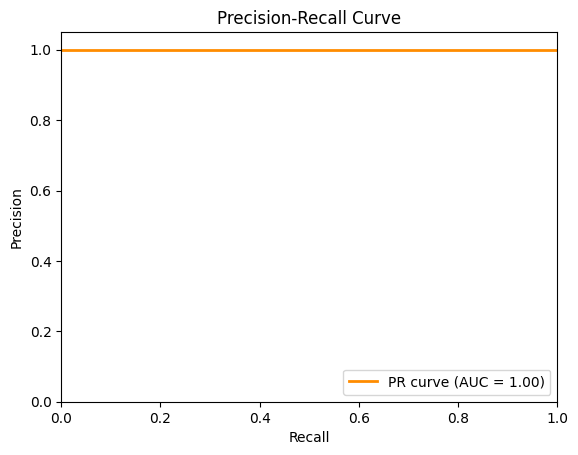

Area Under the Precision-Recall Curve: 1.0
Best threshold: 76.65675074443543


In [23]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Create a binary column indicating whether the actual rainfall was Extreme or not
data['actual_rainfall_binary'] = (data['rainfall_class'] == 'Extreme') & (data['actual_rainfall_class'] == 'Extreme')

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(data['actual_rainfall_binary'], data['error'])
prc_auc = auc(recall, precision)

f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the index of the threshold that maximizes F1 score
best_threshold_idx = np.argmax(f1_scores)

# Get the best threshold
best_threshold = thresholds[best_threshold_idx]


# Plot the precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % prc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Print the AUPRC
print("Area Under the Precision-Recall Curve:", prc_auc)
print("Best threshold:", best_threshold)


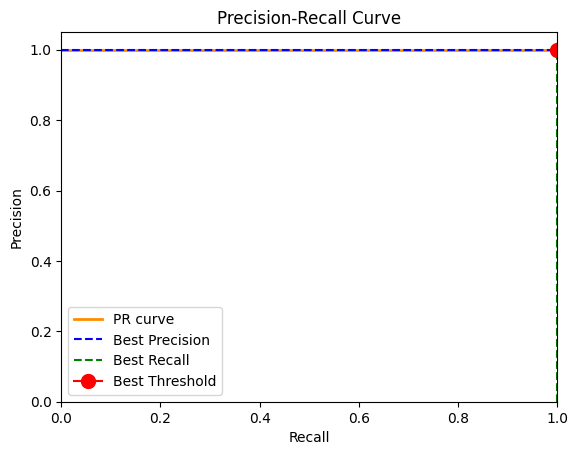

Best threshold: 54.455630194576415


In [31]:
# Create a binary column indicating whether the actual rainfall was Extreme or not
data['actual_rainfall_binary'] = (data['rainfall_class'] == 'Extreme') & (data['actual_rainfall_class'] == 'Extreme')

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(data['actual_rainfall_binary'], data['error'])

# Calculate TNR
tnr = 1 - precision

# Calculate Youden's J statistic for each threshold
j_stat = recall + tnr - 1

# Find the index of the threshold that maximizes J
best_threshold_idx = np.argmax(j_stat)

# Get the best threshold
best_threshold = thresholds[best_threshold_idx]

# Compute the precision and recall at the best threshold
best_precision = precision[best_threshold_idx]
best_recall = recall[best_threshold_idx]

# Plot the precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
plt.plot([0, 1], [best_precision, best_precision], linestyle='--', color='blue', label='Best Precision')
plt.plot([best_recall, best_recall], [0, 1], linestyle='--', color='green', label='Best Recall')
plt.plot([best_recall], [best_precision], marker='o', markersize=10, color="red", label="Best Threshold")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Print the best threshold
print("Best threshold:", best_threshold)
